In [15]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import h5py

In [16]:
#%matplotlib notebook
with h5py.File('train_128.h5','r') as H:
    dataset = np.copy(H['data'])
with h5py.File('train_label.h5','r') as H:
    label = np.copy(H['label'])


# fig = pl.figure(figsize=(6,6))
# pl.title("Input Dataset")
# pl.xlim((-2,2))
# pl.ylim((-2,2))

# dataset = []

# def onclick(event):
#     global dataset
#     cx = event.xdata
#     cy = event.ydata
#     co = event.button
#     dataset.append((cx, cy, co-2))

#     pl.scatter(cx, cy, c=(['b', 'r'])[co > 2], s=100, lw=0)
#     pl.grid(True)

# cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [17]:
%matplotlib inline

In [18]:
dataset = np.array(dataset)
dataset

array([[-1.26502938e+02,  1.63243234e+03, -1.20922145e+03, ...,
         1.11837600e+02,  3.57044951e+01, -6.63192504e-01],
       [ 1.40756479e+03, -4.51681446e+02, -2.59769757e+02, ...,
         9.24883807e+01, -1.46637001e+02, -7.93095667e+01],
       [-7.25430358e+02, -1.10359763e+03,  1.07005341e+02, ...,
        -2.93622934e+01,  1.30540938e+01,  2.86296443e+01],
       ...,
       [ 8.57968820e+02, -1.18125654e+03, -5.24804773e+02, ...,
        -5.73590622e+01, -5.25292580e+01,  9.50972693e+01],
       [-8.07274095e+02, -5.82995915e+02,  4.83379610e+02, ...,
        -1.66679316e+01, -1.83820338e+01, -1.37082853e+01],
       [-1.81559879e+03, -1.22586832e+02,  4.69665973e+02, ...,
        -4.75736174e+01, -6.20747931e+01, -2.06536428e+01]])

In [19]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_derivative(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    def __relu(self,x):
        c = self.__softmax(x)
        
        #x = x - np.max(x)
        return np.maximum(x, 0)
    def __relu_derivative(self,a):
        return np.greater(a, 0).astype(int)
    
    def __softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    #x is output from hidden layer
    #y is label matrix
    def __entropy(self, x, y):
        
        p = softmax(x)
        log_lh = -np.log(p[range(10), y])
        loss = np.sum(log_lh) / m
        return loss
    
    def __entropy_derivative(self, x, y):
        
        p = softmax(x)
        p[range(10),y] -= 1
        p = p/10
        return p
        
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_derivative
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_derivative

In [20]:
#Check relu activation works
a =Activation("relu")
print(a.f(2))
print(a.f(0))
print(a.f(-200))

print(a.f_deriv(100))
print(a.f_deriv(0))
print(a.f_deriv(-200))


0
0
0
1
0
0


In [21]:
class HiddenLayer(object):    
    def __init__(self,n_in, n_out, W=None, b=None,
                 activation='relu'):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        self.activation_deriv=Activation(activation).f_deriv
        # end-snippet-1

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            W_values *= 4
            
        

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    def backward(self, delta):       
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        # return delta_ for next layer
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta_

In [22]:
class MLP:
    """
    """      
    def __init__(self, layers, activation='relu'):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        
        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation=activation))
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # write down the delta in the last layer
        delta=error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta
        
    def backward(self,delta):        
        for layer in reversed(self.layers):
            delta=layer.backward(delta)
            
    def update(self,lr):
        for layer in self.layers:
            layer.W += lr * layer.grad_W
            layer.b += lr * layer.grad_b

    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                
                # backward pass
                loss[it],delta=self.criterion_MSE(y[i],y_hat)
                self.backward(delta)
                
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    def predict(self, x):
        x = np.array(x)
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = nn.forward(x[i,:])
        return output

In [23]:
### Try different MLP models
nn = MLP([2,1], 'relu')
input_data = dataset[:,0:2]
output_data = dataset[:,2]

In [24]:
### Try different learning rate and epochs
MSE = nn.fit(input_data, output_data, learning_rate=0.01, epochs=10)
print('loss:%f'%MSE[-1])

loss:266392.400129


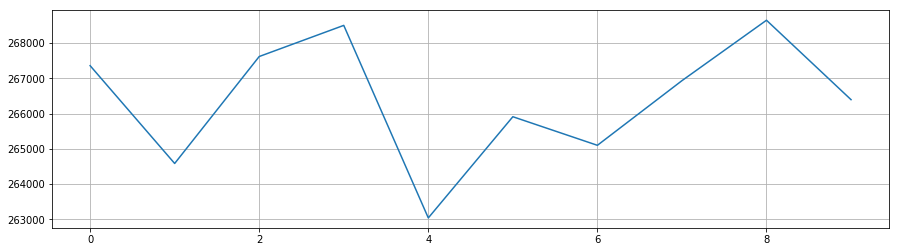

In [25]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

In [26]:
output = nn.predict(input_data)

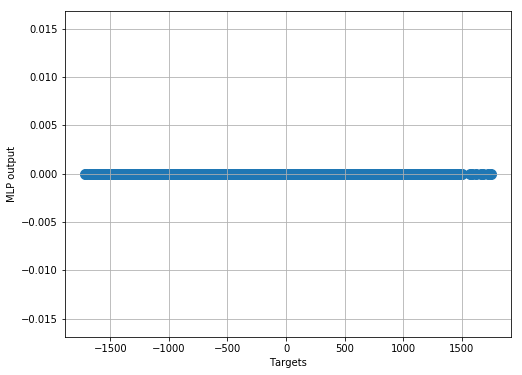

In [27]:
pl.figure(figsize=(8,6))
pl.scatter(output_data, output, s=100)
pl.xlabel('Targets')
pl.ylabel('MLP output')
pl.grid()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Text(0.5,1,'MLP output')

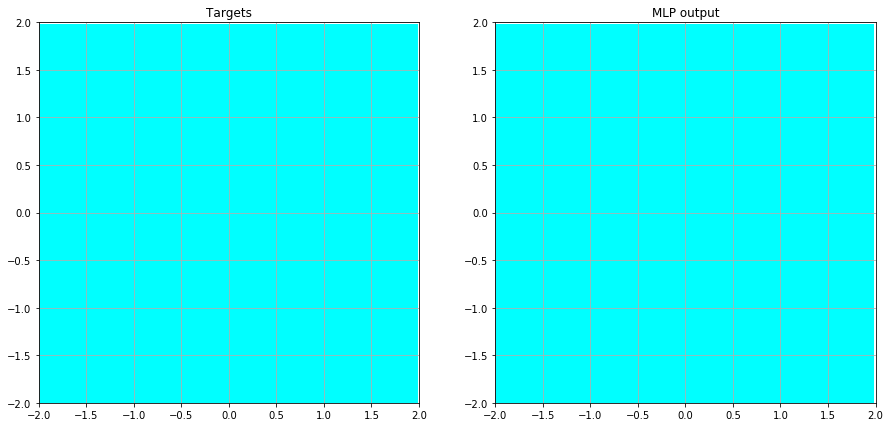

In [28]:
# create a mesh to plot in
xx, yy = np.meshgrid(np.arange(-2, 2, .02),np.arange(-2, 2, .02))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

pl.figure(figsize=(15,7))
pl.subplot(1,2,1)
pl.pcolormesh(xx, yy, Z>0, cmap='cool')
pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[d>0] for d in output_data], s=100)
pl.xlim(-2, 2)
pl.ylim(-2, 2)
pl.grid()
pl.title('Targets')
pl.subplot(1,2,2)
pl.pcolormesh(xx, yy, Z>0, cmap='cool')
pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[d>0] for d in output], s=100)
pl.xlim(-2, 2)
pl.ylim(-2, 2)
pl.grid()
pl.title('MLP output')